In [1]:
! pwd

/cluster/home/taekim/stressed_mice/jupyter_notebooks


In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime

def run_random_forest_feature_selection_by_factor(input_file_path, output_dir=None, top_n=50):
    """
    Perform Random Forest feature selection analysis on genomic data, 
    with separate analyses for each factor of interest.
    
    Parameters:
    -----------
    input_file_path : str
        Path to the input CSV file with genomic data
    output_dir : str, optional
        Directory where output files will be saved. If None, uses the current directory.
    top_n : int, optional
        Number of top features to highlight in detailed analysis, default is 50
        
    Returns:
    --------
    results_dict : dict
        Dictionary containing results for each factor analysis
    importance_dict : dict
        Dictionary containing feature importance DataFrames for each factor
    performance_dict : dict
        Dictionary containing performance metrics for each factor model
    """
    # Set default output directory if none provided
    if output_dir is None:
        output_dir = ''
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define a mapping from NCBI RefSeq accessions to UCSC chromosome names
    # Based on standard mouse genome mapping (assuming this is mouse data from the RefSeq IDs)
    chrom_dict = {
        'NC_000067.7': 'chr1',
        'NC_000067.8': 'chr1',
        'NC_000068.7': 'chr2',
        'NC_000068.8': 'chr2',
        'NC_000069.7': 'chr3',
        'NC_000069.8': 'chr3',
        'NC_000070.7': 'chr4',
        'NC_000070.8': 'chr4',
        'NC_000071.7': 'chr5',
        'NC_000071.8': 'chr5',
        'NC_000072.7': 'chr6',
        'NC_000072.8': 'chr6',
        'NC_000073.7': 'chr7',
        'NC_000073.8': 'chr7',
        'NC_000074.7': 'chr8',
        'NC_000074.8': 'chr8',
        'NC_000075.7': 'chr9',
        'NC_000075.8': 'chr9',
        'NC_000076.7': 'chr10',
        'NC_000076.8': 'chr10',
        'NC_000077.7': 'chr11',
        'NC_000077.8': 'chr11',
        'NC_000078.7': 'chr12',
        'NC_000078.8': 'chr12',
        'NC_000079.7': 'chr13',
        'NC_000079.8': 'chr13',
        'NC_000080.7': 'chr14',
        'NC_000080.8': 'chr14',
        'NC_000081.7': 'chr15',
        'NC_000081.8': 'chr15',
        'NC_000082.7': 'chr16',
        'NC_000082.8': 'chr16',
        'NC_000083.7': 'chr17',
        'NC_000083.8': 'chr17',
        'NC_000084.7': 'chr18',
        'NC_000084.8': 'chr18',
        'NC_000085.7': 'chr19',
        'NC_000085.8': 'chr19',
        'NC_000086.8': 'chrX',
        'NC_000086.9': 'chrX',
        'NC_000087.8': 'chrY',
        'NC_000087.9': 'chrY',
        'NC_005089.1': 'chrM'
    }
    
    # Function to parse bin_id and create new UCSC style ID
    def create_ucsc_style_id(bin_id):
        match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', bin_id)
        if match:
            index = float(match.group(1))
            strand = match.group(2)
            ref_seq = match.group(3)
            
            if ref_seq in chrom_dict:
                # Convert index to integer
                return f"{chrom_dict[ref_seq]}{strand}{int(index)}"
        return bin_id  # Return original if conversion fails

    # Read the data
    print(f"Reading data from {input_file_path}...")
    df = pd.read_csv(input_file_path)

    # Create feature IDs first
    df['FeatureID'] = df['Bin'].astype(str) + '_' + df['Strand'] + df['Chromosome'].astype(str)

    # Now convert these IDs to UCSC style
    df['UCSCFeatureID'] = df['FeatureID'].apply(create_ucsc_style_id)

    # Print some examples to verify the conversion
    print("\nExample UCSC Feature IDs:")
    for i, (orig, ucsc) in enumerate(zip(df['FeatureID'], df['UCSCFeatureID'])):
        if i < 5:  # Show first 5 examples
            print(f"  Original: {orig} → UCSC: {ucsc}")

    # Create pivot table with UCSC-style IDs
    pivot_df = df.pivot_table(index='Sample', 
                             columns='UCSCFeatureID', 
                             values='Median_Normalized_Damage',
                             aggfunc='mean')

    print(f"Data shape: {pivot_df.shape} (samples × features)")

    # Extract sample groups and components
    def extract_group_components(sample_name):
        match = re.search(r'(CRS|Ctrl)_(evening|morning)', sample_name)
        if match:
            treatment = match.group(1)  # CRS or Ctrl
            time = match.group(2)       # evening or morning
            full_group = match.group(0)  # e.g., "CRS_evening"
            return full_group, treatment, time
        else:
            return "Unknown", "Unknown", "Unknown"

    # Create target variables
    samples = pivot_df.index
    sample_info = [extract_group_components(sample) for sample in samples]
    full_groups = [info[0] for info in sample_info]
    treatments = [info[1] for info in sample_info]
    times = [info[2] for info in sample_info]

    # Print group distribution
    print("\nSample group distribution:")
    for group, count in zip(*np.unique(full_groups, return_counts=True)):
        print(f"  {group}: {count} samples")
    
    # Prepare feature data
    X = pivot_df.values
    X = np.nan_to_num(X, nan=0.0)  # Replace NaN with zero

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define the factors to analyze
    factor_analyses = {
        'full_groups': full_groups,               # All groups (CRS_evening, CRS_morning, Ctrl_evening, Ctrl_morning)
        'treatment': treatments,                  # CRS vs Ctrl (regardless of time)
        'time': times,                            # evening vs morning (regardless of treatment)
        'CRS_time': [t for i, t in enumerate(times) if treatments[i] == 'CRS'],  # Time effect within CRS
        'Ctrl_time': [t for i, t in enumerate(times) if treatments[i] == 'Ctrl'],  # Time effect within Ctrl
        'evening_treatment': [tr for i, tr in enumerate(treatments) if times[i] == 'evening'],  # Treatment effect in evening
        'morning_treatment': [tr for i, tr in enumerate(treatments) if times[i] == 'morning']   # Treatment effect in morning
    }
    
    # Filter indices for subset analyses
    CRS_indices = [i for i, tr in enumerate(treatments) if tr == 'CRS']
    Ctrl_indices = [i for i, tr in enumerate(treatments) if tr == 'Ctrl']
    evening_indices = [i for i, t in enumerate(times) if t == 'evening']
    morning_indices = [i for i, t in enumerate(times) if t == 'morning']
    
    factor_indices = {
        'full_groups': list(range(len(full_groups))),
        'treatment': list(range(len(treatments))),
        'time': list(range(len(times))),
        'CRS_time': CRS_indices,
        'Ctrl_time': Ctrl_indices,
        'evening_treatment': evening_indices,
        'morning_treatment': morning_indices
    }
    
    # Store results
    results_dict = {}
    importance_dict = {}
    performance_dict = {}  # New dictionary for performance metrics
    
    # Prepare DataFrame to store top features from all factors
    all_top_features_df = pd.DataFrame()
    
    # Run analysis for each factor
    for factor_name, factor_values in factor_analyses.items():
        print(f"\n{'='*50}")
        print(f"Analyzing factor: {factor_name}")
        
        # Get relevant indices for this analysis
        indices = factor_indices[factor_name]
        
        # Skip if not enough samples
        if len(indices) < 4:  # Need at least a few samples for meaningful analysis
            print(f"Skipping {factor_name} due to insufficient samples.")
            continue
            
        # Filter data
        X_factor = X_scaled[indices]
        y_factor = np.array(factor_values)
        
        # Skip if only one class
        unique_classes = np.unique(y_factor)
        if len(unique_classes) < 2:
            print(f"Skipping {factor_name} due to only one class: {unique_classes[0]}")
            continue
            
        print(f"Classes for {factor_name}: {unique_classes}")
        print(f"Class distribution: {[np.sum(y_factor == c) for c in unique_classes]}")
        
        # Encode labels
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y_factor)
        
        # Train Random Forest
        print(f"Training Random Forest for {factor_name}...")
        rf = RandomForestClassifier(n_estimators=500, random_state=42, 
                                   class_weight='balanced', n_jobs=20)
        
        # === NEW: PERFORMANCE EVALUATION ===
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Calculate cross-validation scores for multiple metrics
        accuracy_scores = cross_val_score(rf, X_factor, y_encoded, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(rf, X_factor, y_encoded, cv=cv, scoring='f1_weighted')
        precision_scores = cross_val_score(rf, X_factor, y_encoded, cv=cv, scoring='precision_weighted')
        recall_scores = cross_val_score(rf, X_factor, y_encoded, cv=cv, scoring='recall_weighted')
        
        # Store performance metrics
        performance_dict[factor_name] = {
            'accuracy': {
                'mean': np.mean(accuracy_scores),
                'std': np.std(accuracy_scores),
                'values': accuracy_scores
            },
            'f1': {
                'mean': np.mean(f1_scores),
                'std': np.std(f1_scores),
                'values': f1_scores
            },
            'precision': {
                'mean': np.mean(precision_scores),
                'std': np.std(precision_scores),
                'values': precision_scores
            },
            'recall': {
                'mean': np.mean(recall_scores),
                'std': np.std(recall_scores),
                'values': recall_scores
            },
            'n_samples': len(y_factor),
            'class_distribution': {str(c): int(np.sum(y_factor == c)) for c in unique_classes}
        }
        
        # Print performance metrics
        print(f"\nPerformance metrics for {factor_name}:")
        print(f"  Accuracy: {performance_dict[factor_name]['accuracy']['mean']:.4f} ± {performance_dict[factor_name]['accuracy']['std']:.4f}")
        print(f"  F1 Score: {performance_dict[factor_name]['f1']['mean']:.4f} ± {performance_dict[factor_name]['f1']['std']:.4f}")
        print(f"  Precision: {performance_dict[factor_name]['precision']['mean']:.4f} ± {performance_dict[factor_name]['precision']['std']:.4f}")
        print(f"  Recall: {performance_dict[factor_name]['recall']['mean']:.4f} ± {performance_dict[factor_name]['recall']['std']:.4f}")
        # === END NEW SECTION ===
        
        # Now train on full dataset for feature importance
        rf.fit(X_factor, y_encoded)
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'Feature': pivot_df.columns,
            'Importance': rf.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        # Extract genomic information from UCSC-style IDs
        def extract_ucsc_info(ucsc_id):
            # Pattern to match UCSC style IDs like chr1+12345
            match = re.match(r'^(chr[^+-]+)([+-])(\d+)$', ucsc_id)
            if match:
                chrom = match.group(1)
                strand = match.group(2)
                position = int(match.group(3))
                return chrom, strand, position
            else:
                # For non-matching IDs, try to extract using original pattern
                match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', ucsc_id)
                if match:
                    bin_val = match.group(1)
                    strand = match.group(2)
                    chrom = match.group(3)
                    return chrom, strand, bin_val
                return "Unknown", "?", "Unknown"
        
        # Add genomic information to importance dataframe
        importance_df['Chromosome'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[0])
        importance_df['Strand'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[1])
        importance_df['Position'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[2])
        
        # Add percentile and cumulative importance to ALL features
        importance_df['Percentile'] = importance_df['Importance'].rank(pct=True) * 100
        importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum() * 100

        # Save all features with enhanced information in one file
        all_features_file = os.path.join(output_dir, f'{factor_name}_all_features_importance.csv')
        importance_df.to_csv(all_features_file, index=False)
        print(f"Saved all features with importance metrics for {factor_name} to {all_features_file}")

        top_n_features = importance_df.head(top_n)
        
        # Add top features to combined DataFrame
        top_features_for_combined = top_n_features.head(top_n).copy()
        top_features_for_combined['Factor'] = factor_name
        top_features_for_combined['Rank'] = range(1, len(top_features_for_combined) + 1)
        all_top_features_df = pd.concat([all_top_features_df, top_features_for_combined], ignore_index=True)
        
        # Print top 10 features
        print(f"Top 10 Features for {factor_name}:")
        for i, (feature, importance) in enumerate(zip(top_n_features['Feature'].head(10), 
                                                    top_n_features['Importance'].head(10))):
            print(f"  {i+1}. {feature}: {importance:.6f}")
        
        # Create a visualization ONLY FOR FULL MODEL AND SPECIFIC FACTORS
        # Check if the factor is one of the main factors we want to plot
        if factor_name in ['full_groups', 'treatment', 'time']:
            plt.figure(figsize=(12, 10))
            plt.barh(np.arange(min(top_n, len(top_n_features))), 
                    top_n_features['Importance'], align='center')
            plt.yticks(np.arange(min(top_n, len(top_n_features))), 
                      [f"{i+1}. {f}" for i, f in enumerate(top_n_features['Feature'])])
            plt.xlabel('Importance')
            plt.title(f'Top {top_n} Features for {factor_name}')
            plt.gca().invert_yaxis()  # Highest importance at the top
            plt.tight_layout()
            
            # Save plot
            top_n_plot_file = os.path.join(output_dir, f'{factor_name}_top_{top_n}_features_plot.png')
            plt.savefig(top_n_plot_file, dpi=300)
            print(f"Saved feature importance plot to {top_n_plot_file}")
        
        # Store results
        results_dict[factor_name] = {
            'classes': label_encoder.classes_,
            'top_features': top_n_features.head(10)['Feature'].tolist(),
            'n_samples': len(y_factor)
        }
        importance_dict[factor_name] = importance_df

    # SAVE A CSV DOCUMENT WHERE TOP 50 FOR EACH FACTOR IS SAVED
    # Sort the combined DataFrame by Factor and Rank
    all_top_features_df = all_top_features_df.sort_values(['Factor', 'Rank'])
    
    # Save to CSV
    combined_top_features_file = os.path.join(output_dir, 'all_factors_top_features.csv')
    all_top_features_df.to_csv(combined_top_features_file, index=False)
    print(f"\nSaved top {top_n} features for all factors to {combined_top_features_file}")
    
    # === NEW: CREATE PERFORMANCE COMPARISON VISUALIZATION ===
    if len(performance_dict) > 1:
        # Create a performance comparison chart
        print("\nCreating performance comparison visualization...")
        
        # Extract metrics for comparison
        factors = list(performance_dict.keys())
        accuracy_means = [performance_dict[f]['accuracy']['mean'] for f in factors]
        f1_means = [performance_dict[f]['f1']['mean'] for f in factors]
        precision_means = [performance_dict[f]['precision']['mean'] for f in factors]
        recall_means = [performance_dict[f]['recall']['mean'] for f in factors]
        
        # Create a DataFrame for easy plotting
        performance_df = pd.DataFrame({
            'Factor': factors,
            'Accuracy': accuracy_means,
            'F1 Score': f1_means,
            'Precision': precision_means,
            'Recall': recall_means
        })
        
        # Save performance comparison to CSV
        perf_file = os.path.join(output_dir, 'model_performance_comparison.csv')
        performance_df.to_csv(perf_file, index=False)
        print(f"Saved performance comparison to {perf_file}")
        
        # Create a bar chart visualization
        plt.figure(figsize=(14, 8))
        
        # Set width of bars
        bar_width = 0.2
        index = np.arange(len(factors))
        
        plt.bar(index - 1.5*bar_width, accuracy_means, bar_width, label='Accuracy')
        plt.bar(index - 0.5*bar_width, f1_means, bar_width, label='F1 Score')
        plt.bar(index + 0.5*bar_width, precision_means, bar_width, label='Precision')
        plt.bar(index + 1.5*bar_width, recall_means, bar_width, label='Recall')
        
        plt.xlabel('Factor')
        plt.ylabel('Score')
        plt.title('Model Performance Comparison Across Factors')
        plt.xticks(index, factors, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels on top of bars
        for i, v in enumerate(accuracy_means):
            plt.text(i - 1.5*bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
        for i, v in enumerate(f1_means):
            plt.text(i - 0.5*bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
        for i, v in enumerate(precision_means):
            plt.text(i + 0.5*bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
        for i, v in enumerate(recall_means):
            plt.text(i + 1.5*bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Save performance comparison plot
        perf_plot_file = os.path.join(output_dir, 'model_performance_comparison_plot.png')
        plt.savefig(perf_plot_file, dpi=300)
        print(f"Saved performance comparison plot to {perf_plot_file}")
        
    # === END NEW SECTION ===
    
    # Create a comparison plot for the top features across factors
    if len(importance_dict) > 1:
        print("\nCreating comparison of top features across factors...")
        
        # Get top 5 features from each factor
        top_features_by_factor = {}
        all_top_features = set()
        
        for factor, imp_df in importance_dict.items():
            top_features = imp_df.head(5)['Feature'].tolist()
            top_features_by_factor[factor] = top_features
            all_top_features.update(top_features)
        
        # Create comparison dataframe
        comparison_data = []
        for feature in all_top_features:
            row = {'Feature': feature}
            for factor, imp_df in importance_dict.items():
                feature_imp = imp_df.loc[imp_df['Feature'] == feature, 'Importance'].values
                row[factor] = feature_imp[0] if len(feature_imp) > 0 else 0
            comparison_data.append(row)
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('Feature')
        print(f"\nNumber of unique features in the comparison heatmap: {len(comparison_df)}")
        
        # Save comparison
        comparison_file = os.path.join(output_dir, 'top_features_comparison.csv')
        comparison_df.to_csv(comparison_file, index=False)
        print(f"Saved feature comparison to {comparison_file}")
        
        # Create heatmap visualization
        feature_cols = comparison_df.columns[1:]  # Skip 'Feature' column
        data_for_heatmap = comparison_df.set_index('Feature')[feature_cols]
        
        plt.figure(figsize=(14, len(all_top_features) * 0.5 + 3))
        sns.heatmap(data_for_heatmap, annot=True, cmap='viridis', fmt='.4f')
        plt.title('Feature Importance Comparison Across Factors')
        plt.tight_layout()
        
        # Save heatmap
        heatmap_file = os.path.join(output_dir, 'feature_importance_comparison_heatmap.png')
        plt.savefig(heatmap_file, dpi=300)
        print(f"Saved comparison heatmap to {heatmap_file}")
    
    return results_dict, importance_dict, performance_dict

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime

def run_random_forest_feature_selection_by_factor(input_file_path, output_data_dir=None, output_plots_dir=None, top_n=50):
    """
    Perform Random Forest feature selection analysis on genomic data, 
    with separate analyses for each factor of interest.
    
    Parameters:
    -----------
    input_file_path : str
        Path to the input CSV file with genomic data
    output_data_dir : str, optional
        Directory where output data files (CSVs) will be saved. If None, uses the current directory.
    output_plots_dir : str, optional
        Directory where output plot files (PNGs) will be saved. If None, uses the same as output_data_dir.
    top_n : int, optional
        Number of top features to highlight in detailed analysis, default is 50
        
    Returns:
    --------
    results_dict : dict
        Dictionary containing results for each factor analysis
    importance_dict : dict
        Dictionary containing feature importance DataFrames for each factor
    performance_dict : dict
        Dictionary containing performance metrics for each factor model
    """
    # Set default output directories if none provided
    if output_data_dir is None:
        output_data_dir = ''
    
    if output_plots_dir is None:
        output_plots_dir = output_data_dir
    
    # Create output directories if they don't exist
    os.makedirs(output_data_dir, exist_ok=True)
    os.makedirs(output_plots_dir, exist_ok=True)
    
    print(f"Output data files will be saved to: {output_data_dir}")
    print(f"Output plot files will be saved to: {output_plots_dir}")
    
    # Define a mapping from NCBI RefSeq accessions to UCSC chromosome names
    # Based on standard mouse genome mapping (assuming this is mouse data from the RefSeq IDs)
    chrom_dict = {
        'NC_000067.7': 'chr1',
        'NC_000067.8': 'chr1',
        'NC_000068.7': 'chr2',
        'NC_000068.8': 'chr2',
        'NC_000069.7': 'chr3',
        'NC_000069.8': 'chr3',
        'NC_000070.7': 'chr4',
        'NC_000070.8': 'chr4',
        'NC_000071.7': 'chr5',
        'NC_000071.8': 'chr5',
        'NC_000072.7': 'chr6',
        'NC_000072.8': 'chr6',
        'NC_000073.7': 'chr7',
        'NC_000073.8': 'chr7',
        'NC_000074.7': 'chr8',
        'NC_000074.8': 'chr8',
        'NC_000075.7': 'chr9',
        'NC_000075.8': 'chr9',
        'NC_000076.7': 'chr10',
        'NC_000076.8': 'chr10',
        'NC_000077.7': 'chr11',
        'NC_000077.8': 'chr11',
        'NC_000078.7': 'chr12',
        'NC_000078.8': 'chr12',
        'NC_000079.7': 'chr13',
        'NC_000079.8': 'chr13',
        'NC_000080.7': 'chr14',
        'NC_000080.8': 'chr14',
        'NC_000081.7': 'chr15',
        'NC_000081.8': 'chr15',
        'NC_000082.7': 'chr16',
        'NC_000082.8': 'chr16',
        'NC_000083.7': 'chr17',
        'NC_000083.8': 'chr17',
        'NC_000084.7': 'chr18',
        'NC_000084.8': 'chr18',
        'NC_000085.7': 'chr19',
        'NC_000085.8': 'chr19',
        'NC_000086.8': 'chrX',
        'NC_000086.9': 'chrX',
        'NC_000087.8': 'chrY',
        'NC_000087.9': 'chrY',
        'NC_005089.1': 'chrM'
    }
    
    # Function to parse bin_id and create new UCSC style ID
    def create_ucsc_style_id(bin_id):
        match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', bin_id)
        if match:
            index = float(match.group(1))
            strand = match.group(2)
            ref_seq = match.group(3)
            
            if ref_seq in chrom_dict:
                # Convert index to integer
                return f"{chrom_dict[ref_seq]}{strand}{int(index)}"
        return bin_id  # Return original if conversion fails

    # Read the data
    print(f"Reading data from {input_file_path}...")
    df = pd.read_csv(input_file_path)

    # Create feature IDs first
    df['FeatureID'] = df['Bin'].astype(str) + '_' + df['Strand'] + df['Chromosome'].astype(str)

    # Now convert these IDs to UCSC style
    df['UCSCFeatureID'] = df['FeatureID'].apply(create_ucsc_style_id)

    # Print some examples to verify the conversion
    print("\nExample UCSC Feature IDs:")
    for i, (orig, ucsc) in enumerate(zip(df['FeatureID'], df['UCSCFeatureID'])):
        if i < 5:  # Show first 5 examples
            print(f"  Original: {orig} → UCSC: {ucsc}")

    # Create pivot table with UCSC-style IDs
    pivot_df = df.pivot_table(index='Sample', 
                             columns='UCSCFeatureID', 
                             values='Median_Normalized_Damage',
                             aggfunc='mean')

    print(f"Data shape: {pivot_df.shape} (samples × features)")

    # Extract sample groups and components
    def extract_group_components(sample_name):
        match = re.search(r'(CRS|Ctrl)_(evening|morning)', sample_name)
        if match:
            treatment = match.group(1)  # CRS or Ctrl
            time = match.group(2)       # evening or morning
            full_group = match.group(0)  # e.g., "CRS_evening"
            return full_group, treatment, time
        else:
            return "Unknown", "Unknown", "Unknown"

    # Create target variables
    samples = pivot_df.index
    sample_info = [extract_group_components(sample) for sample in samples]
    full_groups = [info[0] for info in sample_info]
    treatments = [info[1] for info in sample_info]
    times = [info[2] for info in sample_info]

    # Print group distribution
    print("\nSample group distribution:")
    for group, count in zip(*np.unique(full_groups, return_counts=True)):
        print(f"  {group}: {count} samples")
    
    # Prepare feature data
    X = pivot_df.values
    X = np.nan_to_num(X, nan=0.0)  # Replace NaN with zero

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define the factors to analyze
    factor_analyses = {
        'full_groups': full_groups,               # All groups (CRS_evening, CRS_morning, Ctrl_evening, Ctrl_morning)
        'treatment': treatments,                  # CRS vs Ctrl (regardless of time)
        'time': times,                            # evening vs morning (regardless of treatment)
        'CRS_time': [t for i, t in enumerate(times) if treatments[i] == 'CRS'],  # Time effect within CRS
        'Ctrl_time': [t for i, t in enumerate(times) if treatments[i] == 'Ctrl'],  # Time effect within Ctrl
        'evening_treatment': [tr for i, tr in enumerate(treatments) if times[i] == 'evening'],  # Treatment effect in evening
        'morning_treatment': [tr for i, tr in enumerate(treatments) if times[i] == 'morning']   # Treatment effect in morning
    }
    
    # Filter indices for subset analyses
    CRS_indices = [i for i, tr in enumerate(treatments) if tr == 'CRS']
    Ctrl_indices = [i for i, tr in enumerate(treatments) if tr == 'Ctrl']
    evening_indices = [i for i, t in enumerate(times) if t == 'evening']
    morning_indices = [i for i, t in enumerate(times) if t == 'morning']
    
    factor_indices = {
        'full_groups': list(range(len(full_groups))),
        'treatment': list(range(len(treatments))),
        'time': list(range(len(times))),
        'CRS_time': CRS_indices,
        'Ctrl_time': Ctrl_indices,
        'evening_treatment': evening_indices,
        'morning_treatment': morning_indices
    }
    
    # Store results
    results_dict = {}
    importance_dict = {}
    performance_dict = {}  # Dictionary for performance metrics
    
    # Prepare DataFrame to store top features from all factors
    all_top_features_df = pd.DataFrame()
    
    # Run analysis for each factor
    for factor_name, factor_values in factor_analyses.items():
        print(f"\n{'='*50}")
        print(f"Analyzing factor: {factor_name}")
        
        # Get relevant indices for this analysis
        indices = factor_indices[factor_name]
        
        # Skip if not enough samples
        if len(indices) < 4:  # Need at least a few samples for meaningful analysis
            print(f"Skipping {factor_name} due to insufficient samples.")
            continue
            
        # Filter data
        X_factor = X_scaled[indices]
        y_factor = np.array(factor_values)
        
        # Skip if only one class
        unique_classes = np.unique(y_factor)
        if len(unique_classes) < 2:
            print(f"Skipping {factor_name} due to only one class: {unique_classes[0]}")
            continue
            
        print(f"Classes for {factor_name}: {unique_classes}")
        print(f"Class distribution: {[np.sum(y_factor == c) for c in unique_classes]}")
        
        # Encode labels
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y_factor)
        
        # Train Random Forest
        print(f"Training Random Forest for {factor_name}...")
        rf = RandomForestClassifier(n_estimators=500, random_state=42, 
                                   class_weight='balanced', n_jobs=20)
        
        # Performance evaluation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Calculate cross-validation scores for multiple metrics
        accuracy_scores = cross_val_score(rf, X_factor, y_encoded, cv=cv, scoring='accuracy')
        f1_scores = cross_val_score(rf, X_factor, y_encoded, cv=cv, scoring='f1_weighted')
        precision_scores = cross_val_score(rf, X_factor, y_encoded, cv=cv, scoring='precision_weighted')
        recall_scores = cross_val_score(rf, X_factor, y_encoded, cv=cv, scoring='recall_weighted')
        
        # Store performance metrics
        performance_dict[factor_name] = {
            'accuracy': {
                'mean': np.mean(accuracy_scores),
                'std': np.std(accuracy_scores),
                'values': accuracy_scores
            },
            'f1': {
                'mean': np.mean(f1_scores),
                'std': np.std(f1_scores),
                'values': f1_scores
            },
            'precision': {
                'mean': np.mean(precision_scores),
                'std': np.std(precision_scores),
                'values': precision_scores
            },
            'recall': {
                'mean': np.mean(recall_scores),
                'std': np.std(recall_scores),
                'values': recall_scores
            },
            'n_samples': len(y_factor),
            'class_distribution': {str(c): int(np.sum(y_factor == c)) for c in unique_classes}
        }
        
        # Print performance metrics
        print(f"\nPerformance metrics for {factor_name}:")
        print(f"  Accuracy: {performance_dict[factor_name]['accuracy']['mean']:.4f} ± {performance_dict[factor_name]['accuracy']['std']:.4f}")
        print(f"  F1 Score: {performance_dict[factor_name]['f1']['mean']:.4f} ± {performance_dict[factor_name]['f1']['std']:.4f}")
        print(f"  Precision: {performance_dict[factor_name]['precision']['mean']:.4f} ± {performance_dict[factor_name]['precision']['std']:.4f}")
        print(f"  Recall: {performance_dict[factor_name]['recall']['mean']:.4f} ± {performance_dict[factor_name]['recall']['std']:.4f}")
        
        # Now train on full dataset for feature importance
        rf.fit(X_factor, y_encoded)
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'Feature': pivot_df.columns,
            'Importance': rf.feature_importances_
        })
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        # Extract genomic information from UCSC-style IDs
        def extract_ucsc_info(ucsc_id):
            # Pattern to match UCSC style IDs like chr1+12345
            match = re.match(r'^(chr[^+-]+)([+-])(\d+)$', ucsc_id)
            if match:
                chrom = match.group(1)
                strand = match.group(2)
                position = int(match.group(3))
                return chrom, strand, position
            else:
                # For non-matching IDs, try to extract using original pattern
                match = re.match(r'^(\d+\.\d+)_([+-])(.+)$', ucsc_id)
                if match:
                    bin_val = match.group(1)
                    strand = match.group(2)
                    chrom = match.group(3)
                    return chrom, strand, bin_val
                return "Unknown", "?", "Unknown"
        
        # Add genomic information to importance dataframe
        importance_df['Chromosome'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[0])
        importance_df['Strand'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[1])
        importance_df['Position'] = importance_df['Feature'].apply(lambda x: extract_ucsc_info(x)[2])
        
        # Add percentile and cumulative importance to ALL features
        importance_df['Percentile'] = importance_df['Importance'].rank(pct=True) * 100
        importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum() * 100

        # Save all features with enhanced information in one file (DATA)
        all_features_file = os.path.join(output_data_dir, f'{factor_name}_all_features_importance.csv')
        importance_df.to_csv(all_features_file, index=False)
        print(f"Saved all features with importance metrics for {factor_name} to {all_features_file}")

        top_n_features = importance_df.head(top_n)
        
        # Add top features to combined DataFrame
        top_features_for_combined = top_n_features.head(top_n).copy()
        top_features_for_combined['Factor'] = factor_name
        top_features_for_combined['Rank'] = range(1, len(top_features_for_combined) + 1)
        all_top_features_df = pd.concat([all_top_features_df, top_features_for_combined], ignore_index=True)
        
        # Print top 10 features
        print(f"Top 10 Features for {factor_name}:")
        for i, (feature, importance) in enumerate(zip(top_n_features['Feature'].head(10), 
                                                    top_n_features['Importance'].head(10))):
            print(f"  {i+1}. {feature}: {importance:.6f}")
        
        # Create a visualization ONLY FOR FULL MODEL AND SPECIFIC FACTORS
        # Check if the factor is one of the main factors we want to plot
        if factor_name in ['full_groups', 'treatment', 'time']:
            plt.figure(figsize=(12, 10))
            plt.barh(np.arange(min(top_n, len(top_n_features))), 
                    top_n_features['Importance'], align='center')
            plt.yticks(np.arange(min(top_n, len(top_n_features))), 
                      [f"{i+1}. {f}" for i, f in enumerate(top_n_features['Feature'])])
            plt.xlabel('Importance')
            plt.title(f'Top {top_n} Features for {factor_name}')
            plt.gca().invert_yaxis()  # Highest importance at the top
            plt.tight_layout()
            
            # Save plot (PLOT)
            top_n_plot_file = os.path.join(output_plots_dir, f'{factor_name}_top_{top_n}_features_plot.png')
            plt.savefig(top_n_plot_file, dpi=300)
            print(f"Saved feature importance plot to {top_n_plot_file}")
        
        # Store results
        results_dict[factor_name] = {
            'classes': label_encoder.classes_,
            'top_features': top_n_features.head(10)['Feature'].tolist(),
            'n_samples': len(y_factor)
        }
        importance_dict[factor_name] = importance_df

    # SAVE A CSV DOCUMENT WHERE TOP 50 FOR EACH FACTOR IS SAVED
    # Sort the combined DataFrame by Factor and Rank
    all_top_features_df = all_top_features_df.sort_values(['Factor', 'Rank'])
    
    # Save to CSV (DATA)
    combined_top_features_file = os.path.join(output_data_dir, 'all_factors_top_features.csv')
    all_top_features_df.to_csv(combined_top_features_file, index=False)
    print(f"\nSaved top {top_n} features for all factors to {combined_top_features_file}")
    
    # CREATE PERFORMANCE COMPARISON VISUALIZATION
    if len(performance_dict) > 1:
        # Create a performance comparison chart
        print("\nCreating performance comparison visualization...")
        
        # Extract metrics for comparison
        factors = list(performance_dict.keys())
        accuracy_means = [performance_dict[f]['accuracy']['mean'] for f in factors]
        f1_means = [performance_dict[f]['f1']['mean'] for f in factors]
        precision_means = [performance_dict[f]['precision']['mean'] for f in factors]
        recall_means = [performance_dict[f]['recall']['mean'] for f in factors]
        
        # Create a DataFrame for easy plotting
        performance_df = pd.DataFrame({
            'Factor': factors,
            'Accuracy': accuracy_means,
            'F1 Score': f1_means,
            'Precision': precision_means,
            'Recall': recall_means
        })
        
        # Save performance comparison to CSV (DATA)
        perf_file = os.path.join(output_data_dir, 'model_performance_comparison.csv')
        performance_df.to_csv(perf_file, index=False)
        print(f"Saved performance comparison to {perf_file}")
        
        # Create a bar chart visualization
        plt.figure(figsize=(14, 8))
        
        # Set width of bars
        bar_width = 0.2
        index = np.arange(len(factors))
        
        plt.bar(index - 1.5*bar_width, accuracy_means, bar_width, label='Accuracy')
        plt.bar(index - 0.5*bar_width, f1_means, bar_width, label='F1 Score')
        plt.bar(index + 0.5*bar_width, precision_means, bar_width, label='Precision')
        plt.bar(index + 1.5*bar_width, recall_means, bar_width, label='Recall')
        
        plt.xlabel('Factor')
        plt.ylabel('Score')
        plt.title('Model Performance Comparison Across Factors')
        plt.xticks(index, factors, rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels on top of bars
        for i, v in enumerate(accuracy_means):
            plt.text(i - 1.5*bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
        for i, v in enumerate(f1_means):
            plt.text(i - 0.5*bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
        for i, v in enumerate(precision_means):
            plt.text(i + 0.5*bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
        for i, v in enumerate(recall_means):
            plt.text(i + 1.5*bar_width, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Save performance comparison plot (PLOT)
        perf_plot_file = os.path.join(output_plots_dir, 'model_performance_comparison_plot.png')
        plt.savefig(perf_plot_file, dpi=300)
        print(f"Saved performance comparison plot to {perf_plot_file}")
    
    # Create a comparison plot for the top features across factors
    if len(importance_dict) > 1:
        print("\nCreating comparison of top features across factors...")
        
        # Get top 5 features from each factor
        top_features_by_factor = {}
        all_top_features = set()
        
        for factor, imp_df in importance_dict.items():
            top_features = imp_df.head(5)['Feature'].tolist()
            top_features_by_factor[factor] = top_features
            all_top_features.update(top_features)
        
        # Create comparison dataframe
        comparison_data = []
        for feature in all_top_features:
            row = {'Feature': feature}
            for factor, imp_df in importance_dict.items():
                feature_imp = imp_df.loc[imp_df['Feature'] == feature, 'Importance'].values
                row[factor] = feature_imp[0] if len(feature_imp) > 0 else 0
            comparison_data.append(row)
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('Feature')
        print(f"\nNumber of unique features in the comparison heatmap: {len(comparison_df)}")
        
        # Save comparison (DATA)
        comparison_file = os.path.join(output_data_dir, 'top_features_comparison.csv')
        comparison_df.to_csv(comparison_file, index=False)
        print(f"Saved feature comparison to {comparison_file}")
        
        # Create heatmap visualization
        feature_cols = comparison_df.columns[1:]  # Skip 'Feature' column
        data_for_heatmap = comparison_df.set_index('Feature')[feature_cols]
        
        plt.figure(figsize=(14, len(all_top_features) * 0.5 + 3))
        sns.heatmap(data_for_heatmap, annot=True, cmap='viridis', fmt='.4f')
        plt.title('Feature Importance Comparison Across Factors')
        plt.tight_layout()
        
        # Save heatmap (PLOT)
        heatmap_file = os.path.join(output_plots_dir, 'feature_importance_comparison_heatmap.png')
        plt.savefig(heatmap_file, dpi=300)
        print(f"Saved comparison heatmap to {heatmap_file}")
    
    return results_dict, importance_dict, performance_dict

Output data files will be saved to: ../data_rf/bin100000
Output plot files will be saved to: ../images/rf_results/bin100000
Reading data from ../data_normalized/cleaned_Normalized_100000.csv...

Example UCSC Feature IDs:
  Original: 3000000.0_+NC_000067.7 → UCSC: chr1+3000000
  Original: 3000000.0_-NC_000067.7 → UCSC: chr1-3000000
  Original: 3100000.0_+NC_000067.7 → UCSC: chr1+3100000
  Original: 3100000.0_-NC_000067.7 → UCSC: chr1-3100000
  Original: 3200000.0_+NC_000067.7 → UCSC: chr1+3200000
Data shape: (20, 53168) (samples × features)

Sample group distribution:
  CRS_evening: 5 samples
  CRS_morning: 5 samples
  Ctrl_evening: 5 samples
  Ctrl_morning: 5 samples

Analyzing factor: full_groups
Classes for full_groups: ['CRS_evening' 'CRS_morning' 'Ctrl_evening' 'Ctrl_morning']
Class distribution: [5, 5, 5, 5]
Training Random Forest for full_groups...


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Performance metrics for full_groups:
  Accuracy: 0.4000 ± 0.1225
  F1 Score: 0.2583 ± 0.0928
  Precision: 0.1917 ± 0.0726
  Recall: 0.4000 ± 0.1225
Saved all features with importance metrics for full_groups to ../data_rf/bin100000/full_groups_all_features_importance.csv
Top 10 Features for full_groups:
  1. chr7-17400000: 0.002816
  2. chr8-10200000: 0.002796
  3. chrX+43500000: 0.002639
  4. chr1+149700000: 0.002182
  5. chr6+84900000: 0.002125
  6. chr9+71200000: 0.001991
  7. chrY-72100000: 0.001959
  8. chr18+14200000: 0.001853
  9. chr5-74100000: 0.001831
  10. chr1-40700000: 0.001799
Saved feature importance plot to ../images/rf_results/bin100000/full_groups_top_50_features_plot.png

Analyzing factor: treatment
Classes for treatment: ['CRS' 'Ctrl']
Class distribution: [10, 10]
Training Random Forest for treatment...

Performance metrics for treatment:
  Accuracy: 0.5000 ± 0.2236
  F1 Score: 0.4733 ± 0.2389
  Precision: 0.5000 ± 0.2981
  Recall: 0.5000 ± 0.2236
Saved all features

/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Performance metrics for time:
  Accuracy: 0.9000 ± 0.2000
  F1 Score: 0.8667 ± 0.2667
  Precision: 0.8500 ± 0.3000
  Recall: 0.9000 ± 0.2000
Saved all features with importance metrics for time to ../data_rf/bin100000/time_all_features_importance.csv
Top 10 Features for time:
  1. chr7+144800000: 0.006000
  2. chr17+13300000: 0.006000
  3. chr17+38000000: 0.006000
  4. chr16+94000000: 0.005636
  5. chr12+102300000: 0.004000
  6. chrY-36800000: 0.004000
  7. chr3-147100000: 0.004000
  8. chrY+81200000: 0.004000
  9. chr17-13700000: 0.004000
  10. chr13+39600000: 0.004000
Saved feature importance plot to ../images/rf_results/bin100000/time_top_50_features_plot.png

Analyzing factor: CRS_time
Classes for CRS_time: ['evening' 'morning']
Class distribution: [5, 5]
Training Random Forest for CRS_time...


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Performance metrics for CRS_time:
  Accuracy: 0.9000 ± 0.2000
  F1 Score: 0.8667 ± 0.2667
  Precision: 0.8500 ± 0.3000
  Recall: 0.9000 ± 0.2000
Saved all features with importance metrics for CRS_time to ../data_rf/bin100000/CRS_time_all_features_importance.csv
Top 10 Features for CRS_time:
  1. chrX+18100000: 0.004016
  2. chr5-115900000: 0.004016
  3. chr7-89200000: 0.004016
  4. chr10+82000000: 0.004016
  5. chr2+158000000: 0.004016
  6. chr3-68200000: 0.004016
  7. chr1-30000000: 0.004016
  8. chr3+83100000: 0.004016
  9. chr8+46300000: 0.004016
  10. chr7-79500000: 0.002008

Analyzing factor: Ctrl_time
Classes for Ctrl_time: ['evening' 'morning']
Class distribution: [5, 5]
Training Random Forest for Ctrl_time...


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Performance metrics for Ctrl_time:
  Accuracy: 0.9000 ± 0.2000
  F1 Score: 0.8667 ± 0.2667
  Precision: 0.8500 ± 0.3000
  Recall: 0.9000 ± 0.2000
Saved all features with importance metrics for Ctrl_time to ../data_rf/bin100000/Ctrl_time_all_features_importance.csv
Top 10 Features for Ctrl_time:
  1. chr5+95800000: 0.004016
  2. chr17+71700000: 0.004016
  3. chr6+69100000: 0.004016
  4. chrY+84200000: 0.004016
  5. chrX+74200000: 0.004016
  6. chrX-89000000: 0.004016
  7. chrY-39400000: 0.004016
  8. chrX+161700000: 0.002008
  9. chr10+58100000: 0.002008
  10. chr10-64200000: 0.002008

Analyzing factor: evening_treatment
Classes for evening_treatment: ['CRS' 'Ctrl']
Class distribution: [5, 5]
Training Random Forest for evening_treatment...


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Performance metrics for evening_treatment:
  Accuracy: 0.4000 ± 0.2000
  F1 Score: 0.2667 ± 0.1333
  Precision: 0.2000 ± 0.1000
  Recall: 0.4000 ± 0.2000
Saved all features with importance metrics for evening_treatment to ../data_rf/bin100000/evening_treatment_all_features_importance.csv
Top 10 Features for evening_treatment:
  1. chr11-27200000: 0.004016
  2. chr14-69100000: 0.004016
  3. chr16+80900000: 0.004016
  4. chr1+178500000: 0.004016
  5. chr9-72000000: 0.002008
  6. chr8-49100000: 0.002008
  7. chr4-105500000: 0.002008
  8. chr7+111200000: 0.002008
  9. chr2+161200000: 0.002008
  10. chr10-93100000: 0.002008

Analyzing factor: morning_treatment
Classes for morning_treatment: ['CRS' 'Ctrl']
Class distribution: [5, 5]
Training Random Forest for morning_treatment...


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Performance metrics for morning_treatment:
  Accuracy: 0.6000 ± 0.3742
  F1 Score: 0.5333 ± 0.4000
  Precision: 0.5000 ± 0.4183
  Recall: 0.6000 ± 0.3742
Saved all features with importance metrics for morning_treatment to ../data_rf/bin100000/morning_treatment_all_features_importance.csv
Top 10 Features for morning_treatment:
  1. chr11+115100000: 0.004016
  2. chr11+104000000: 0.004016
  3. chr1-30000000: 0.004016
  4. chr15-79800000: 0.004016
  5. chr17-33300000: 0.004016
  6. chrY-18500000: 0.004016
  7. chr8-91300000: 0.004016
  8. chr14-101500000: 0.004016
  9. chrY-8800000: 0.004016
  10. chr6+9300000: 0.004016

Saved top 50 features for all factors to ../data_rf/bin100000/all_factors_top_features.csv

Creating performance comparison visualization...
Saved performance comparison to ../data_rf/bin100000/model_performance_comparison.csv
Saved performance comparison plot to ../images/rf_results/bin100000/model_performance_comparison_plot.png

Creating comparison of top features acr

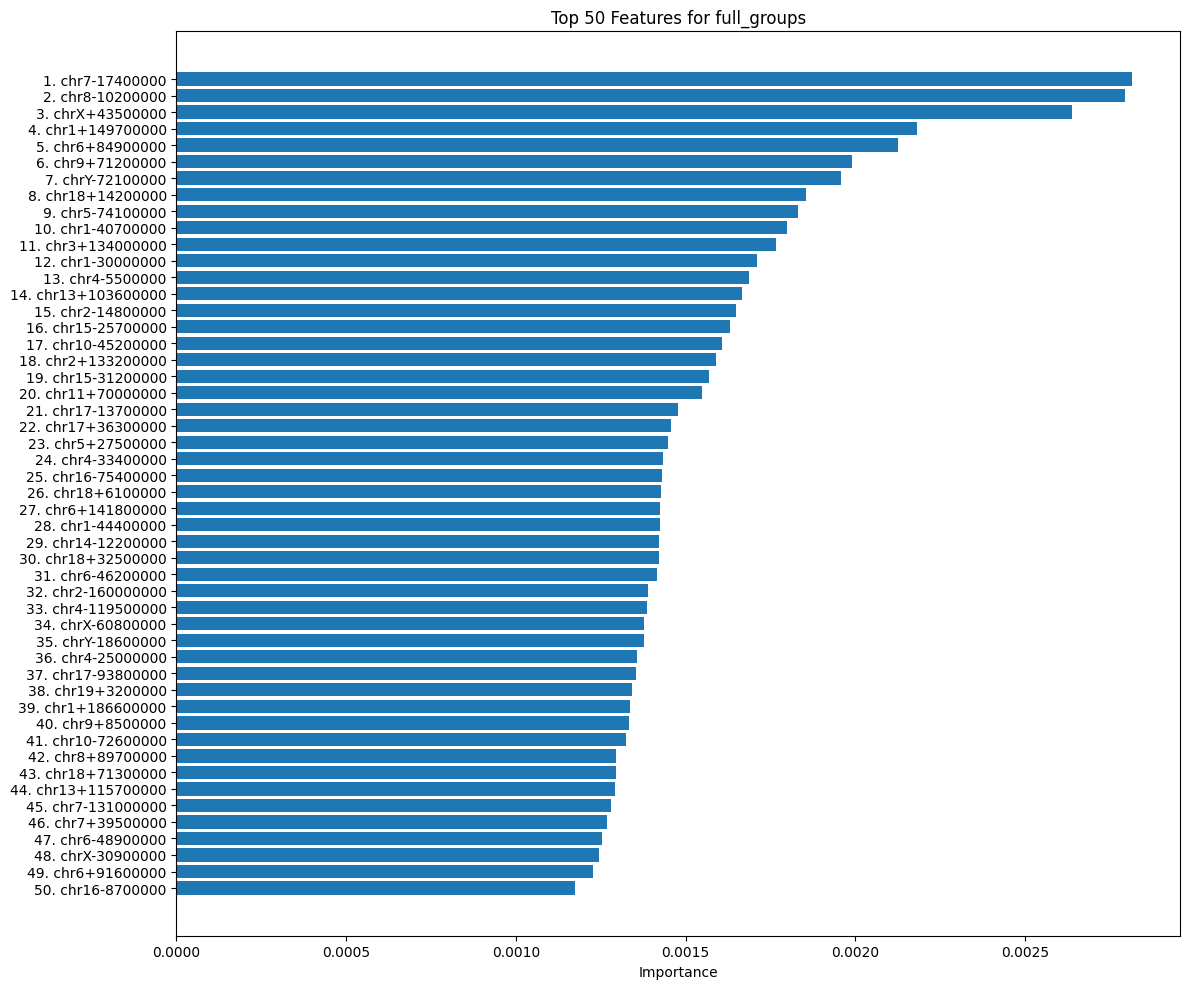

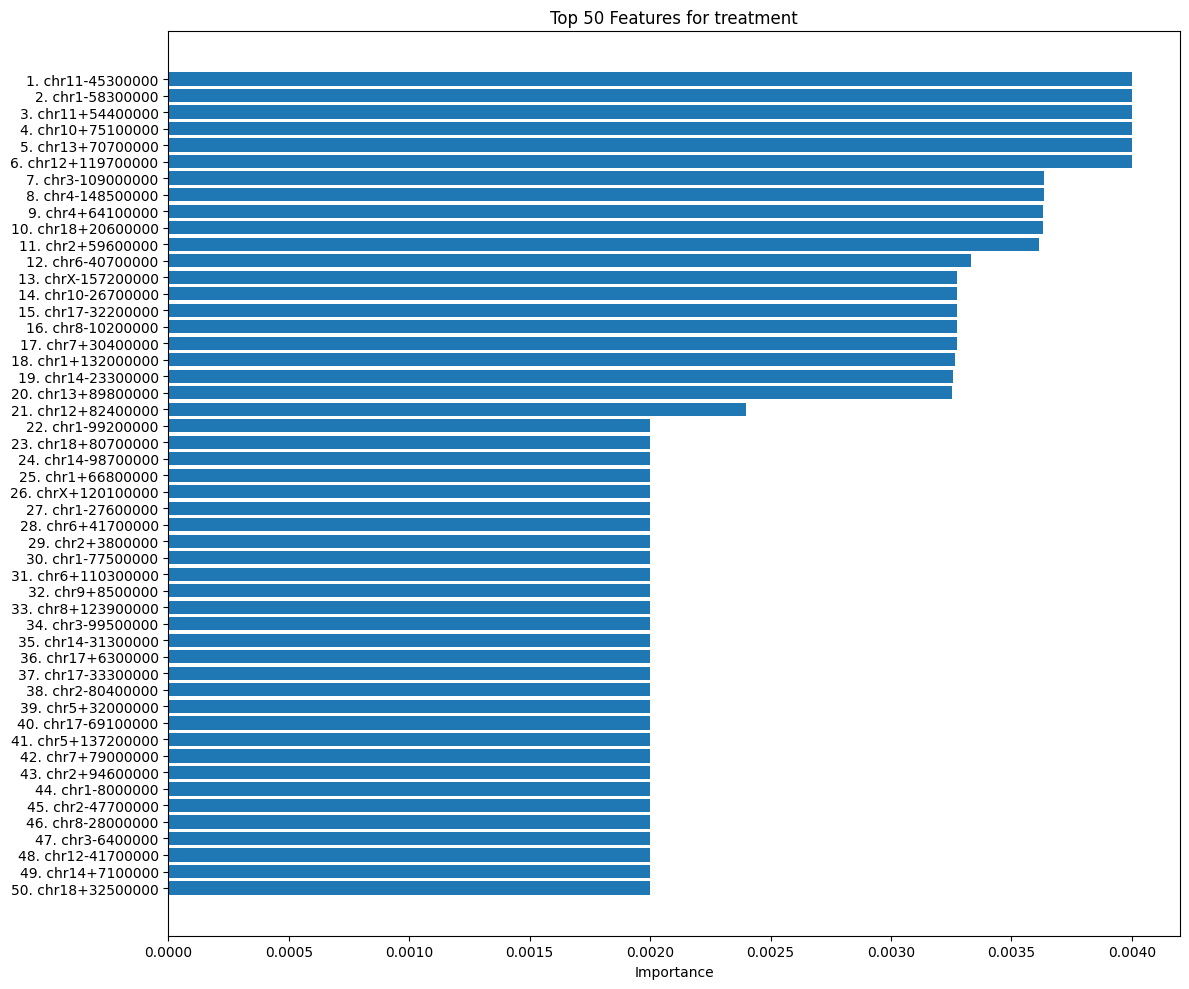

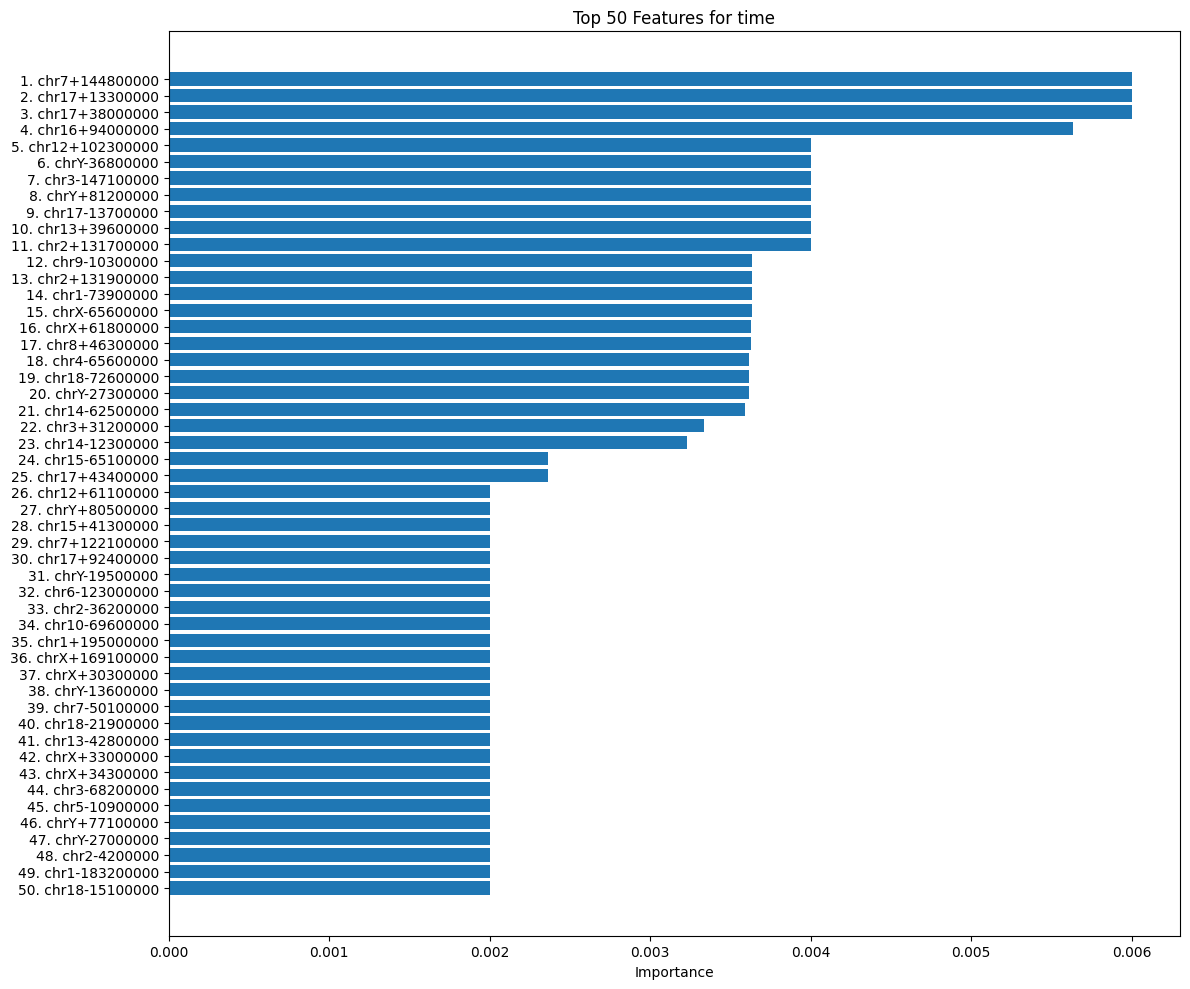

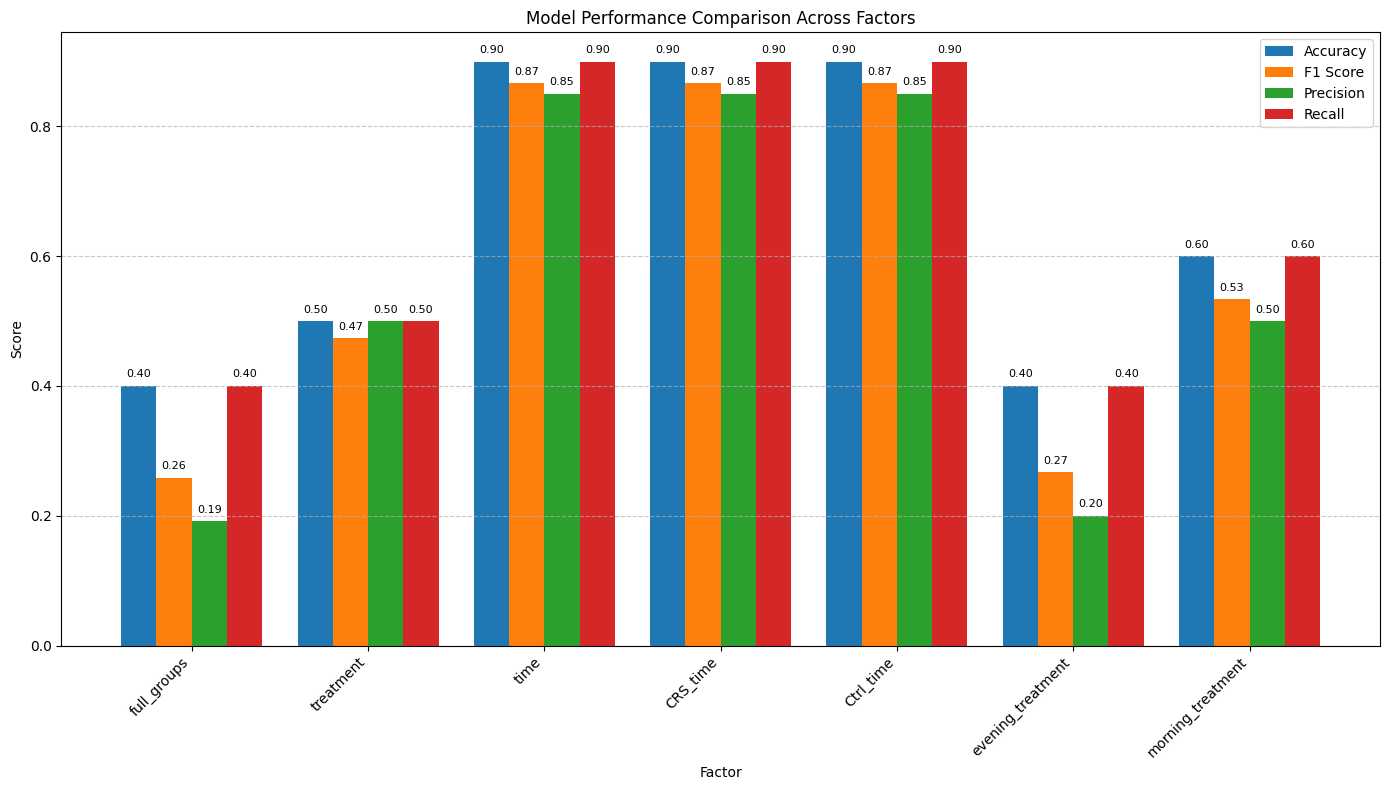

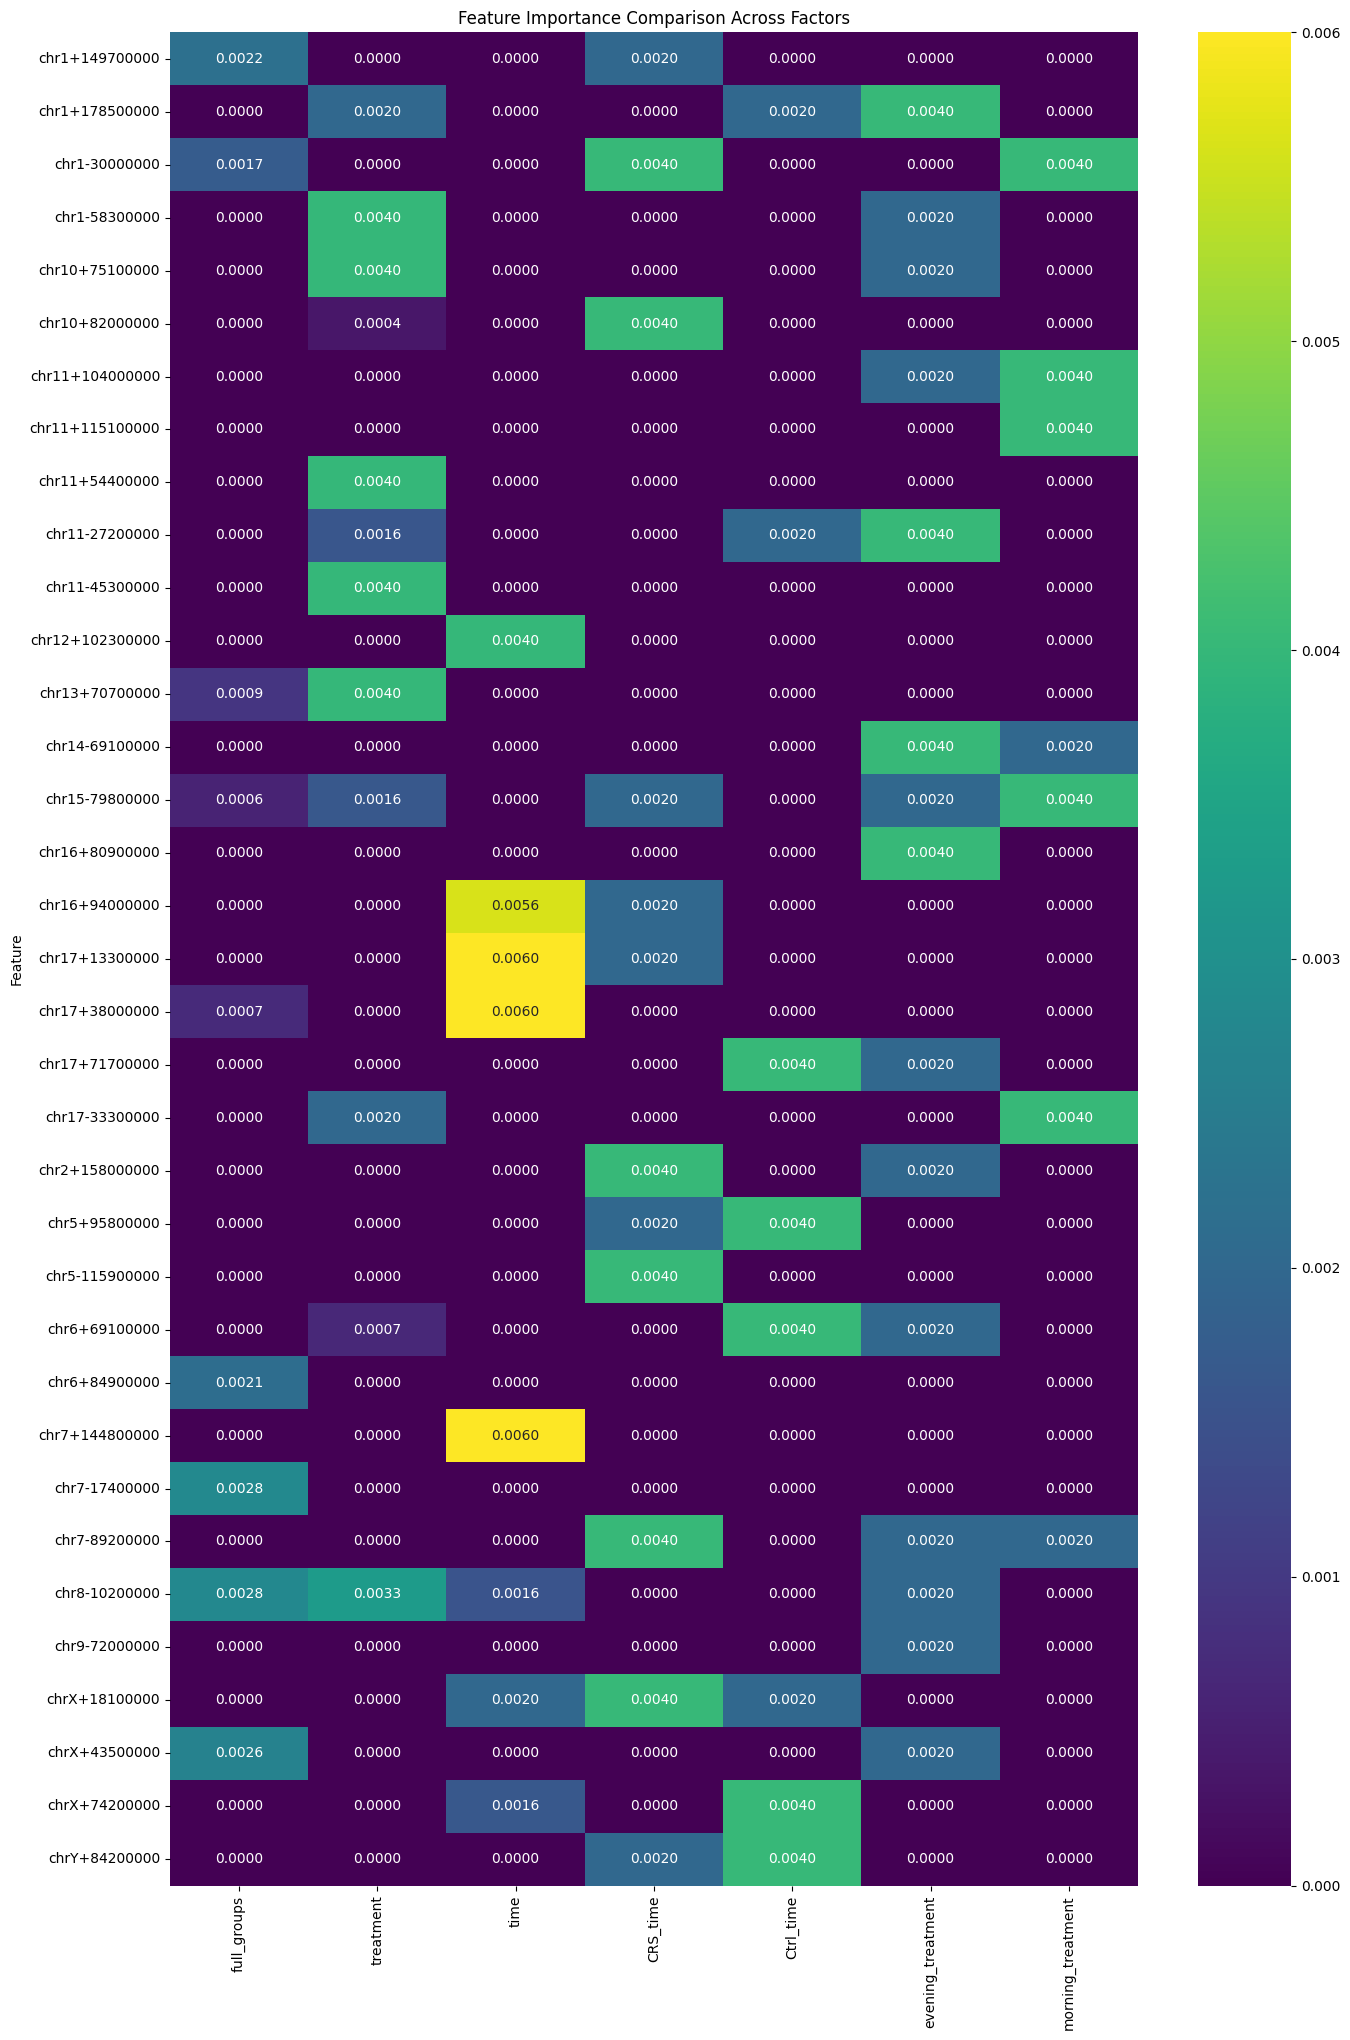

In [4]:
# Run your original function with performance evaluation enabled
results_dict, importance_dict, performance_dict = run_random_forest_feature_selection_by_factor(
   '../data_normalized/cleaned_Normalized_100000.csv', 
    '../data_rf/bin100000', '../images/rf_results/bin100000')

# Optionally compare model performance
#compare_model_performance(performance_dict, '../data_rf/bin100000')